# Text classification with movie reviews

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

### Load data

In [2]:
vocab_size = 10000

In [3]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

* binary classification : negative (0) or positive (1).
* The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

In [4]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print("Test entries    : {}, labels: {}".format(len(test_data), len(test_labels)))

Training entries: 25000, labels: 25000
Test entries    : 25000, labels: 25000


In [5]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Convert the integers back to words

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Convert the data

* arrays of integers must be converted to tensors.
* 배열이 모두 같은 길이를 갖도록 padding 처리.

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [10]:
train_data.shape

(25000, 256)

In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### Build the model

In [12]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))  # vocab_size = 10000 --> 16 node
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# Create a validation set
x_val = test_data[:10000]
y_val = test_labels[:10000]

x_test = test_data[10000:]
y_test = test_labels[10000:]

In [15]:
history = model.fit(train_data,
                    train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 25000 samples, validate on 10000 samples
Epoch 1/30
25000/25000 [==============================] - 1s 45us/sample - loss: 0.6904 - acc: 0.6114 - val_loss: 0.6853 - val_acc: 0.6978
Epoch 2/30
25000/25000 [==============================] - 1s 31us/sample - loss: 0.6738 - acc: 0.7088 - val_loss: 0.6587 - val_acc: 0.7472
Epoch 3/30
25000/25000 [==============================] - 1s 31us/sample - loss: 0.6330 - acc: 0.7697 - val_loss: 0.6073 - val_acc: 0.7804
Epoch 4/30
25000/25000 [==============================] - 1s 31us/sample - loss: 0.5679 - acc: 0.8114 - val_loss: 0.5396 - val_acc: 0.8150
Epoch 5/30
25000/25000 [==============================] - 1s 31us/sample - loss: 0.4929 - acc: 0.8422 - val_loss: 0.4730 - val_acc: 0.8325
Epoch 6/30
25000/25000 [==============================] - 1s 32us/sample - loss: 0.4256 - acc: 0.8630 - val_loss: 0.4194 - val_acc: 0.8474
Epoch 7/30
25000/25000 [==============================] - 1s 31us/sample - loss: 0.3725 - acc: 0.8764 - val_loss: 0.

### Evaluate the model

In [16]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

25000/25000 - 1s - loss: 0.3238 - acc: 0.8772
[0.3237677892112732, 0.87716]


In [17]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

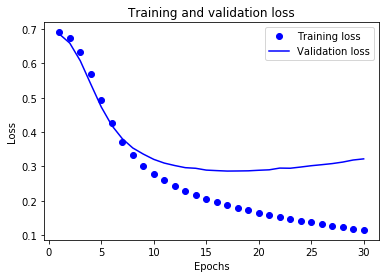

In [20]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, 'bo', label='Training loss')   # "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

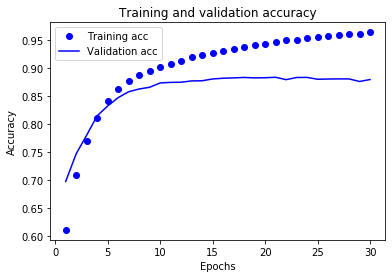

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()